In [1]:
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torchinfo import summary
from safetensors.torch import save_model, load_model
import matplotlib.pyplot as plt
import cv2

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Data Manipulation

In [3]:
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [4]:
dataset = datasets.ImageFolder(root="data/Skyfinder/picked", transform=data_transforms)

train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

In [5]:
batch_size = 16

# put custom dataset to dataloader
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
# check shapes of dataloader
feature, label = next(iter(train_dl))
feature.shape, label.shape

(torch.Size([16, 3, 128, 128]), torch.Size([16]))

### Create Model

A VQ-VAE is just like an VAE but vectors instead are used in a similar fashion to KNN.

In [7]:
# hyperparameters

input_dim = 3
output_dim = input_dim
hidden_dim = 1024
latent_dim = 128
n_embeddings = 512
beta = 0.25

In [8]:
class Encoder(nn.Module):

    def __init__(self, input_dim=input_dim, hidden_dim=hidden_dim, output_dim=latent_dim, kernel_sizes=(4, 4, 3, 1), stride=2):
        super(Encoder, self).__init__()

        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_sizes

        self.stride_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_size=kernel_1, stride=stride, padding=1)
        self.stride_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=kernel_2, stride=stride, padding=1)

        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_3, padding=1)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_4)

        self.proj = nn.Conv2d(hidden_dim, output_dim, kernel_4)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.stride_conv_1(x)
        x = self.stride_conv_2(x)

        x = self.relu(x)
        y = self.residual_conv_1(x)
        y = y+x

        x = self.relu(y)
        x = self.residual_conv_2(x)
        y = y+x

        y = self.proj(y)

        return y

In [9]:
class VQEmbeddingEMA(nn.Module):
    def __init__(self, n_embeddings=n_embeddings, embedding_dim=latent_dim, commitment_cost=beta, decay=0.99, epsilon=1e-5):
        super(VQEmbeddingEMA, self).__init__()

        self.commitment_cost= commitment_cost
        self.decay = decay
        self.epsilon = epsilon

        init_bound = 1 / n_embeddings
        embedding = torch.Tensor(n_embeddings, embedding_dim)
        embedding.uniform_(-init_bound, init_bound)

        self.register_buffer("embedding", embedding)
        self.register_buffer("ema_count", torch.zeros(n_embeddings))
        self.register_buffer("ema_weight", self.embedding.clone())
    
    def get_random_codebook(self, random_indices):
        quantized = F.embedding(random_indices, self.embedding)
        quantized = quantized.transpose(1, 3)

        return quantized
    
    def forward(self, x):
        m, d = self.embedding.size()
        x_flat = x.detach().reshape(-1, d)

        distances = (-torch.cdist(x_flat, self.embedding)) ** 2

        indices = torch.argmin(distances.float(), dim=-1)
        encodings = F.one_hot(indices, m).float()
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)

        if self.training:
            self.ema_count = self.decay * self.ema_count + (1- self.decay) * torch.sum(encodings, dim=0)
            n = torch.sum(self.ema_count)
            self.ema_count = (self.ema_count + self.epsilon) / (n + m * self.epsilon) * n

            dw = torch.matmul(encodings.t(), x_flat)
            self.ema_weight = self.decay * self.ema_weight + (1 - self.decay) * dw
            self.embedding = self.ema_weight / self.ema_count.unsqueeze(-1)

        codebook_loss = F.mse_loss(x.detach(), quantized)
        e_latent_loss = F.mse_loss(x, quantized.detach())
        commitment_loss = self.commitment_cost * e_latent_loss

        quantized = x + (quantized - x).detach()

        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs+1e-10)))

        return quantized, commitment_loss, codebook_loss, perplexity

In [10]:
class Decoder(nn.Module):
    def __init__(self, input_dim=latent_dim, hidden_dim=hidden_dim, output_dim=output_dim, kernel_sizes=(1, 3, 2, 2), stride=2):
        super(Decoder, self).__init__()

        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_sizes

        self.inv_proj = nn.Conv2d(input_dim, hidden_dim, kernel_size=1)

        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=kernel_1)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=kernel_2, padding=1)

        self.stride_transconv_1 = nn.ConvTranspose2d(hidden_dim, hidden_dim, stride=stride, kernel_size=kernel_3)
        self.stride_transconv_2 = nn.ConvTranspose2d(hidden_dim, output_dim, stride=stride, kernel_size=kernel_4)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.inv_proj(x)

        y = self.residual_conv_1(x)
        y = y + x
        x = self.relu(y)

        y = self.residual_conv_2(x)
        y = y + x
        x = self.relu(y)

        x = self.stride_transconv_1(x)
        x = self.stride_transconv_2(x)

        return x

In [11]:
class VQVAE(nn.Module):
    def __init__(self, encoder, codebook, decoder):
        super(VQVAE, self).__init__()

        self.encoder = encoder
        self.codebook = codebook
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        quantized_z, commitment_loss, codebook_loss, perplexity = self.codebook(x)
        x = self.decoder(quantized_z)

        return x, commitment_loss, codebook_loss, perplexity

In [12]:
encoder = Encoder()
codebook = VQEmbeddingEMA()
decoder = Decoder()

model = VQVAE(encoder=encoder, codebook=codebook, decoder=decoder).to(device)
summary(model, input_size=(16, 3, 128, 128), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
VQVAE                                    [16, 3, 128, 128]         --
├─Encoder: 1-1                           [16, 128, 32, 32]         --
│    └─Conv2d: 2-1                       [16, 1024, 64, 64]        50,176
│    └─Conv2d: 2-2                       [16, 1024, 32, 32]        16,778,240
│    └─ReLU: 2-3                         [16, 1024, 32, 32]        --
│    └─Conv2d: 2-4                       [16, 1024, 32, 32]        9,438,208
│    └─ReLU: 2-5                         [16, 1024, 32, 32]        --
│    └─Conv2d: 2-6                       [16, 1024, 32, 32]        1,049,600
│    └─Conv2d: 2-7                       [16, 128, 32, 32]         131,200
├─VQEmbeddingEMA: 1-2                    [16, 128, 32, 32]         --
├─Decoder: 1-3                           [16, 3, 128, 128]         --
│    └─Conv2d: 2-8                       [16, 1024, 32, 32]        132,096
│    └─Conv2d: 2-9                       [16, 102

### Loss Function and Optimizer

In [13]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

### Training Model

In [14]:
torch.manual_seed(42)

epochs = 50

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    
    # TRAINING
    train_loss =  0
    model.train()
    for batch, (X, y) in enumerate(train_dl):

        X = X.to(device)

        # forward pass
        train_x_hat, train_commitment_loss, train_codebook_loss, train_complexity = model(X)

        # metrics
        loss = loss_fn(train_x_hat, X) + train_commitment_loss * beta + train_codebook_loss
        train_loss += loss

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # print metrics
    train_loss /= len(train_dl)
    print(f"Train Loss: {train_loss:.4f}, Complexity: {train_complexity:.4f}")

    
    # TESTING
    test_loss = 0
    model.eval()
    with torch.inference_mode():
        for X, y in test_dl:

            X = X.to(device)

            # forward pass
            test_x_hat, test_commitment_loss, test_codebook_loss, test_complexity = model(X)

            # metrics
            test_loss += loss_fn(test_x_hat, X) + test_commitment_loss * beta + test_codebook_loss

        # print metrics
        test_loss /= len(test_dl)
        print(f"Test Loss: {test_loss:.4f}, Complexity: {test_complexity:.4f}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
------
Train Loss: 0.1319, Complexity: 14.6321


  2%|▏         | 1/50 [00:04<04:02,  4.95s/it]

Test Loss: 0.1176, Complexity: 12.9277
Epoch: 1
------
Train Loss: 0.0631, Complexity: 22.4603


  4%|▍         | 2/50 [00:09<03:53,  4.86s/it]

Test Loss: 0.0577, Complexity: 22.7130
Epoch: 2
------
Train Loss: 0.0563, Complexity: 38.6930


  6%|▌         | 3/50 [00:14<03:51,  4.93s/it]

Test Loss: 0.0569, Complexity: 44.2395
Epoch: 3
------
Train Loss: 0.0687, Complexity: 25.6250


  8%|▊         | 4/50 [00:19<03:48,  4.97s/it]

Test Loss: 0.0983, Complexity: 12.5781
Epoch: 4
------
Train Loss: 0.1020, Complexity: 20.9574


 10%|█         | 5/50 [00:24<03:44,  5.00s/it]

Test Loss: 0.1607, Complexity: 15.5744
Epoch: 5
------
Train Loss: 0.1541, Complexity: 20.8688


 12%|█▏        | 6/50 [00:29<03:37,  4.95s/it]

Test Loss: 0.1847, Complexity: 29.5046
Epoch: 6
------
Train Loss: 0.2149, Complexity: 18.5497


 14%|█▍        | 7/50 [00:34<03:31,  4.91s/it]

Test Loss: 0.2327, Complexity: 32.6932
Epoch: 7
------
Train Loss: 0.2143, Complexity: 36.6958


 16%|█▌        | 8/50 [00:39<03:24,  4.87s/it]

Test Loss: 0.2115, Complexity: 22.8385
Epoch: 8
------
Train Loss: 0.1664, Complexity: 34.7075


 18%|█▊        | 9/50 [00:44<03:18,  4.84s/it]

Test Loss: 0.1347, Complexity: 22.4536
Epoch: 9
------
Train Loss: 0.1107, Complexity: 36.7222


 20%|██        | 10/50 [00:48<03:14,  4.85s/it]

Test Loss: 0.0916, Complexity: 19.8846
Epoch: 10
------
Train Loss: 0.0823, Complexity: 23.8450


 22%|██▏       | 11/50 [00:54<03:11,  4.92s/it]

Test Loss: 0.0831, Complexity: 27.4768
Epoch: 11
------
Train Loss: 0.0812, Complexity: 32.9151


 24%|██▍       | 12/50 [00:58<03:06,  4.90s/it]

Test Loss: 0.1176, Complexity: 30.9280
Epoch: 12
------
Train Loss: 0.0777, Complexity: 40.4057


 26%|██▌       | 13/50 [01:03<03:01,  4.90s/it]

Test Loss: 0.0921, Complexity: 34.6920
Epoch: 13
------
Train Loss: 0.0690, Complexity: 46.0745


 28%|██▊       | 14/50 [01:08<02:57,  4.93s/it]

Test Loss: 0.0696, Complexity: 24.5209
Epoch: 14
------
Train Loss: 0.0663, Complexity: 51.8024


 30%|███       | 15/50 [01:13<02:52,  4.93s/it]

Test Loss: 0.0686, Complexity: 25.2521
Epoch: 15
------
Train Loss: 0.0664, Complexity: 46.9898


 32%|███▏      | 16/50 [01:18<02:46,  4.88s/it]

Test Loss: 0.0693, Complexity: 24.3384
Epoch: 16
------
Train Loss: 0.0662, Complexity: 48.7565


 34%|███▍      | 17/50 [01:23<02:40,  4.85s/it]

Test Loss: 0.0700, Complexity: 44.2073
Epoch: 17
------
Train Loss: 0.0643, Complexity: 50.7884


 36%|███▌      | 18/50 [01:28<02:35,  4.86s/it]

Test Loss: 0.0751, Complexity: 39.6073
Epoch: 18
------
Train Loss: 0.0616, Complexity: 77.2433


 38%|███▊      | 19/50 [01:33<02:31,  4.88s/it]

Test Loss: 0.0580, Complexity: 33.0210
Epoch: 19
------
Train Loss: 0.0609, Complexity: 61.9661


 40%|████      | 20/50 [01:37<02:26,  4.88s/it]

Test Loss: 0.0794, Complexity: 38.0645
Epoch: 20
------
Train Loss: 0.0597, Complexity: 59.7716


 42%|████▏     | 21/50 [01:42<02:21,  4.89s/it]

Test Loss: 0.0597, Complexity: 41.4726
Epoch: 21
------
Train Loss: 0.0573, Complexity: 65.9632


 44%|████▍     | 22/50 [01:47<02:18,  4.94s/it]

Test Loss: 0.0658, Complexity: 43.9712
Epoch: 22
------
Train Loss: 0.0561, Complexity: 44.2174


 46%|████▌     | 23/50 [01:52<02:13,  4.93s/it]

Test Loss: 0.0713, Complexity: 39.6729
Epoch: 23
------
Train Loss: 0.0538, Complexity: 63.9849


 48%|████▊     | 24/50 [01:57<02:07,  4.89s/it]

Test Loss: 0.0579, Complexity: 27.9792
Epoch: 24
------
Train Loss: 0.0520, Complexity: 64.6089


 50%|█████     | 25/50 [02:02<02:01,  4.86s/it]

Test Loss: 0.0638, Complexity: 55.6671
Epoch: 25
------
Train Loss: 0.0511, Complexity: 68.0565


 52%|█████▏    | 26/50 [02:07<01:56,  4.85s/it]

Test Loss: 0.0489, Complexity: 37.3145
Epoch: 26
------
Train Loss: 0.0497, Complexity: 59.7230


 54%|█████▍    | 27/50 [02:12<01:52,  4.88s/it]

Test Loss: 0.0569, Complexity: 45.4937
Epoch: 27
------
Train Loss: 0.0498, Complexity: 47.9466


 56%|█████▌    | 28/50 [02:17<01:49,  4.98s/it]

Test Loss: 0.0512, Complexity: 45.0491
Epoch: 28
------
Train Loss: 0.0487, Complexity: 71.7867


 58%|█████▊    | 29/50 [02:22<01:45,  5.03s/it]

Test Loss: 0.0465, Complexity: 34.0767
Epoch: 29
------
Train Loss: 0.0479, Complexity: 58.1923


 60%|██████    | 30/50 [02:27<01:40,  5.04s/it]

Test Loss: 0.0489, Complexity: 46.3075
Epoch: 30
------
Train Loss: 0.0476, Complexity: 71.6977


 62%|██████▏   | 31/50 [02:32<01:36,  5.06s/it]

Test Loss: 0.0448, Complexity: 39.9377
Epoch: 31
------
Train Loss: 0.0446, Complexity: 62.2791


 64%|██████▍   | 32/50 [02:37<01:30,  5.05s/it]

Test Loss: 0.0535, Complexity: 48.6061
Epoch: 32
------
Train Loss: 0.0462, Complexity: 82.4038


 66%|██████▌   | 33/50 [02:42<01:25,  5.03s/it]

Test Loss: 0.0443, Complexity: 41.2778
Epoch: 33
------
Train Loss: 0.0434, Complexity: 55.2139


 68%|██████▊   | 34/50 [02:47<01:20,  5.01s/it]

Test Loss: 0.0464, Complexity: 33.3211
Epoch: 34
------
Train Loss: 0.0446, Complexity: 75.8473


 70%|███████   | 35/50 [02:52<01:14,  4.99s/it]

Test Loss: 0.0510, Complexity: 47.8707
Epoch: 35
------
Train Loss: 0.0424, Complexity: 49.3187


 72%|███████▏  | 36/50 [02:57<01:09,  4.98s/it]

Test Loss: 0.0432, Complexity: 57.7813
Epoch: 36
------
Train Loss: 0.0430, Complexity: 85.9167


 74%|███████▍  | 37/50 [03:02<01:04,  4.98s/it]

Test Loss: 0.0487, Complexity: 39.6875
Epoch: 37
------
Train Loss: 0.0424, Complexity: 76.1683


 76%|███████▌  | 38/50 [03:07<00:59,  4.97s/it]

Test Loss: 0.0502, Complexity: 48.0081
Epoch: 38
------
Train Loss: 0.0426, Complexity: 92.0233


 78%|███████▊  | 39/50 [03:12<00:54,  4.97s/it]

Test Loss: 0.0427, Complexity: 55.8026
Epoch: 39
------
Train Loss: 0.0409, Complexity: 83.5515


 80%|████████  | 40/50 [03:17<00:49,  4.96s/it]

Test Loss: 0.0421, Complexity: 33.3793
Epoch: 40
------
Train Loss: 0.0405, Complexity: 76.8263


 82%|████████▏ | 41/50 [03:22<00:44,  4.96s/it]

Test Loss: 0.0534, Complexity: 41.8824
Epoch: 41
------
Train Loss: 0.0415, Complexity: 92.4528


 84%|████████▍ | 42/50 [03:27<00:39,  4.96s/it]

Test Loss: 0.0545, Complexity: 44.5727
Epoch: 42
------
Train Loss: 0.0424, Complexity: 107.7110


 86%|████████▌ | 43/50 [03:32<00:34,  4.96s/it]

Test Loss: 0.0483, Complexity: 47.0920
Epoch: 43
------
Train Loss: 0.0411, Complexity: 84.9714


 88%|████████▊ | 44/50 [03:37<00:29,  4.96s/it]

Test Loss: 0.0490, Complexity: 56.9834
Epoch: 44
------
Train Loss: 0.0401, Complexity: 67.2005


 90%|█████████ | 45/50 [03:42<00:24,  4.96s/it]

Test Loss: 0.0386, Complexity: 38.4076
Epoch: 45
------
Train Loss: 0.0397, Complexity: 71.2100


 92%|█████████▏| 46/50 [03:47<00:19,  4.96s/it]

Test Loss: 0.0462, Complexity: 53.6660
Epoch: 46
------
Train Loss: 0.0386, Complexity: 49.9337


 94%|█████████▍| 47/50 [03:52<00:14,  4.96s/it]

Test Loss: 0.0393, Complexity: 51.1531
Epoch: 47
------
Train Loss: 0.0399, Complexity: 75.1237


 96%|█████████▌| 48/50 [03:57<00:09,  4.96s/it]

Test Loss: 0.0392, Complexity: 36.1451
Epoch: 48
------
Train Loss: 0.0406, Complexity: 135.1016


 98%|█████████▊| 49/50 [04:02<00:04,  4.96s/it]

Test Loss: 0.0441, Complexity: 48.5086
Epoch: 49
------
Train Loss: 0.0396, Complexity: 57.0160


100%|██████████| 50/50 [04:07<00:00,  4.94s/it]

Test Loss: 0.0468, Complexity: 47.1850


### Testing Model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


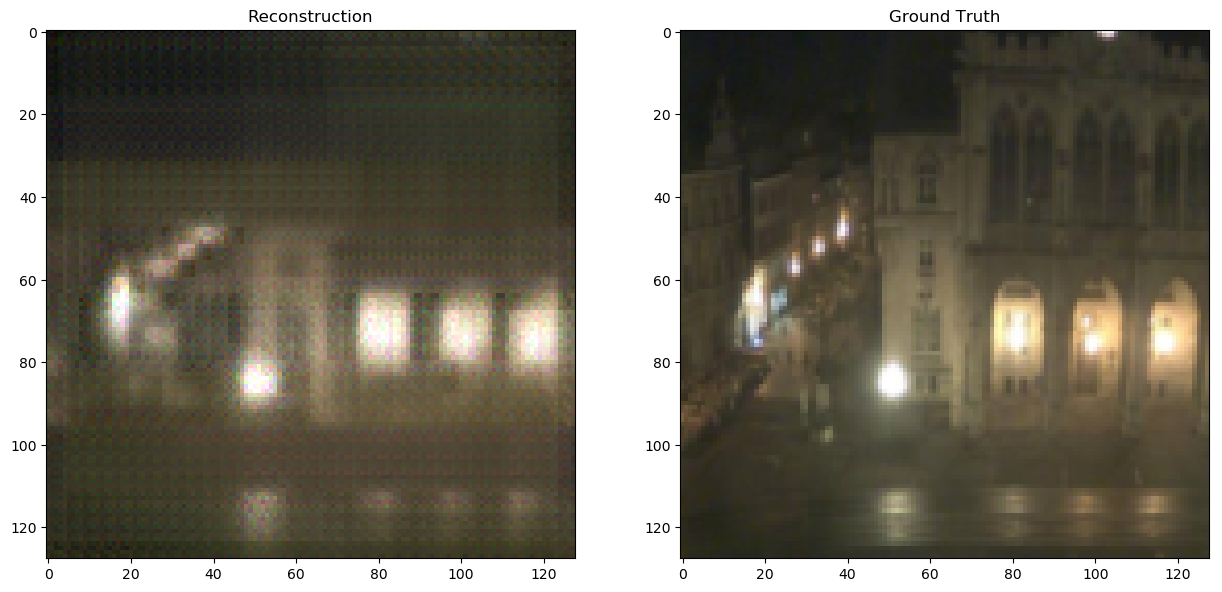

In [27]:
model.eval()

X, y = next(iter(train_dl))
X, y = X[0, :, :].to(device), y[0].to(device)

sample_reconst, sample_commitment_loss, sample_codebook_loss, sample_complexity = model(X)
sample_reconst = sample_reconst.reshape(3, 128, 128).permute(1, 2, 0).detach().cpu().numpy()

X_img = X.reshape(3, 128, 128).permute(1, 2, 0).detach().cpu().numpy()

plt.figure(figsize=(15, 8))

plt.subplot(121)
plt.title("Reconstruction")
plt.imshow(sample_reconst)

plt.subplot(122)
plt.title("Ground Truth")
plt.imshow(X_img)